In [116]:
import clickhouse_connect
import pandas as pd
import polars as pl
import numpy as np
import plotly.express as px
import sys
import json

In [117]:
client = clickhouse_connect.get_client(host='hub.publichealthhq.xyz', port=18123, username='default', password='Password123!')

In [118]:
client.command('USE cps_00004')
#result = client.query('SELECT DISTINCT COUNTY FROM cps_00004 WHERE COUNTY IS NOT NULL LIMIT 100')
#result = client.query('SELECT * FROM cps_00004 WHERE YEAR > 1999 LIMIT 1')
result = client.query('SELECT INCTOT, FTOTVAL FROM cps_00004 LIMIT 10')
result.result_rows

[(0, None),
 (999999999, None),
 (999999999, None),
 (1692, None),
 (1522, None),
 (1740, None),
 (2300, None),
 (0, None),
 (0, None),
 (0, None)]

In [119]:
""" focus on income
 important variables: 
 INCTOT - total personal income
 FTOTVAL - total family income
 ADJGINC - adjusted gross income
"""

' focus on income\n important variables: \n INCTOT - total personal income\n FTOTVAL - total family income\n ADJGINC - adjusted gross income\n'

In [133]:
#finding state to average income mapping
client.command('USE cps_00004')
result = client.query("""
SELECT
    STATEFIP,
    YEAR,
    ROUND(AVG(INCTOT)) AS avg_INCTOT,
    ROUND(AVG(FTOTVAL)) AS avg_FTOTVAL
FROM
    cps_00004
WHERE
    YEAR > 1999
    AND
    INCTOT != 999999999
    AND 
    FTOTVAL != 9999999999
GROUP BY 
    STATEFIP,
    YEAR
ORDER BY
    STATEFIP, 
    YEAR
""")

In [159]:
state_income = pd.DataFrame(result.named_results())
#state_income.head()
# merge with state name and state abbrev csv
state_info = pd.read_csv('us-state-ansi-fips.csv', skipinitialspace=True)
state_info.rename(columns={'st':'STATEFIP'}, inplace=True)
state_info.rename(columns={'stusps':'STATE_ABBREV'}, inplace=True)
state_info.rename(columns={'stname':'STATE_NAME'}, inplace=True)
list(state_info.columns)
# check types
state_income['STATEFIP'] = state_income['STATEFIP'].astype(str)
state_info['STATEFIP'] = state_info['STATEFIP'].astype(str)
state_merged = pd.merge(state_income, state_info, on='STATEFIP', how='left')
state_merged.head()

,STATEFIP,YEAR,avg_INCTOT,avg_FTOTVAL,STATE_NAME,STATE_ABBREV
0,1,2000,22383.0,48455.0,Alabama,AL
1,1,2001,23447.0,53766.0,Alabama,AL
2,1,2002,24878.0,54886.0,Alabama,AL
3,1,2003,25527.0,56029.0,Alabama,AL
4,1,2004,26461.0,57530.0,Alabama,AL


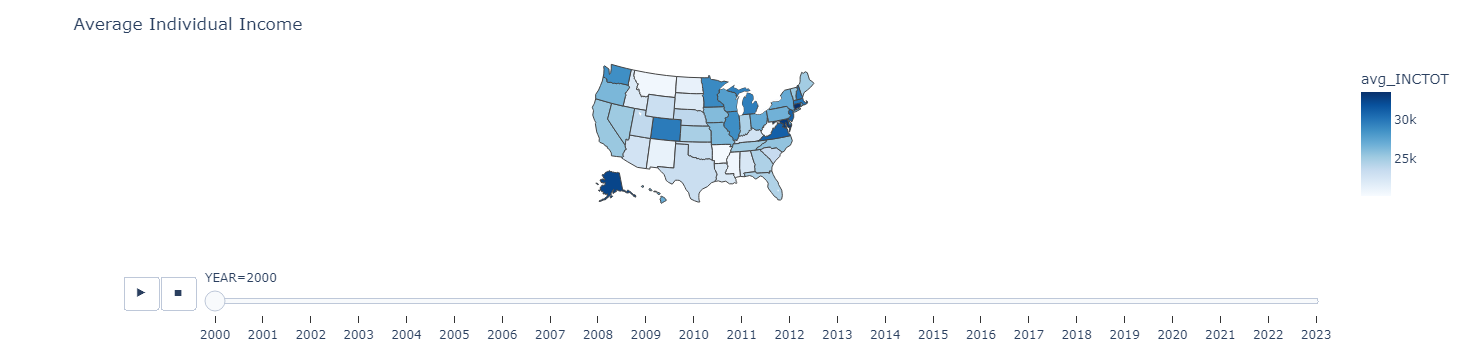

In [172]:
# choropleth map with geojson data
# TODO: try bubble map as well
# trying YEAR = 2005 on avg_INCTOT
# nevermind, theres some kind of issue with the geojson data
#with open('us-states.json', 'r') as file:
    #geojson_states = json.load(file)

income_2005 = state_merged[state_income['YEAR'] == 2005]
fig = px.choropleth(state_merged, locations='STATE_ABBREV', locationmode='USA-states', color='avg_INCTOT', scope='usa',color_continuous_scale='Blues', animation_frame='YEAR')
fig.update_layout(
    title_text = 'Average Individual Income'
)
fig.show()

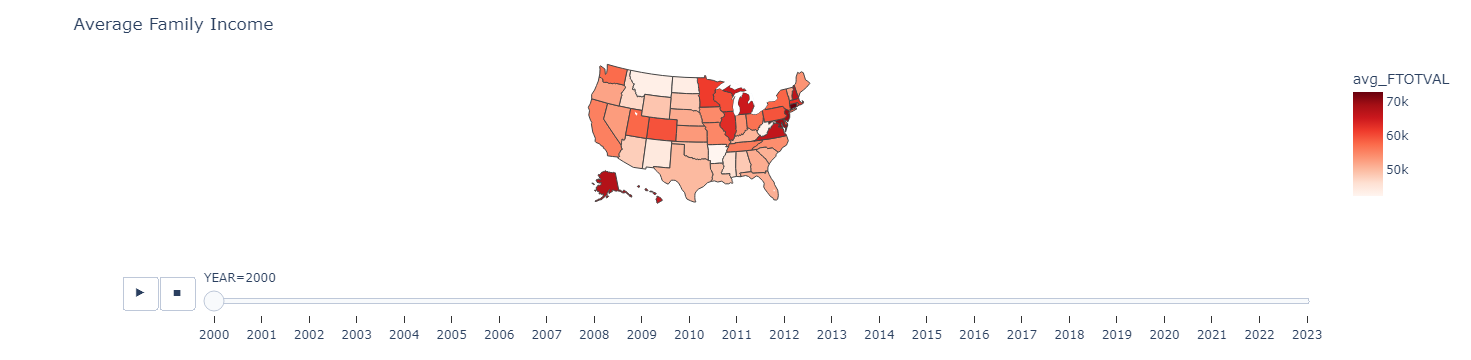

In [171]:
#avg family income
fig = px.choropleth(state_merged, locations='STATE_ABBREV', locationmode='USA-states', color='avg_FTOTVAL', scope='usa',color_continuous_scale='Reds', animation_frame='YEAR')
fig.update_layout(
    title_text = 'Average Family Income'
)
fig.show()